# The classification goal is to predict if the client will subscribe a term deposit (variable y).

# background:

   The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed. 


# Input variables:
# bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   
# related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
  
# other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

# Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Dataset Citation:

[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

Available at: [pdf] http://hdl.handle.net/1822/14838 [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

In [ ]:
import os
import numpy as np
import pandas as pd
from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit
import statsmodels.formula.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime
import seaborn as sns
import warnings
import io

np.random.seed(12345)
plt.rc('figure', figsize=(20, 10))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)
warnings.filterwarnings("ignore")

# Our temporal data types
from datetime import datetime
from datetime import timedelta

# For grabbing data sets
import requests

# For hiding code blocks, as they aren't necessary at this point
from IPython.display import HTML

#os.chdir('C:/Users/llee/Documents/Hard Drive/Personal Documents/Data Science Certificate/Data Science 2 - Statistics/Group Project') 
# where I saved the csv data file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank-full.csv to bank-full.csv


# Data Preparation Section

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['bank-full.csv']), sep = ';')
df.head()

NameError: ignored

In [ ]:
# Adding fields (type category) for yes/no fields.
df.y.astype('category').cat.codes
df['purchased_loan'] = df.y.astype('category').cat.codes
df['default_cat'] = df.default.astype('category').cat.codes
df['housing_cat'] = df.housing.astype('category').cat.codes
df['loan_cat'] = df.loan.astype('category').cat.codes
df['job_cat'] = df.job.astype('category').cat.codes
df['marital_cat'] = df.marital.astype('category').cat.codes
df['education_cat'] = df.education.astype('category').cat.codes


In [ ]:
# Transform data by adding bins for Age -- Mean : 41
bins = [0, 20, 30, 40, 50, 60, 70, 100]
age_bins = pd.cut(df['age'], bins, right=True, labels=None)
df['age_bin'] = age_bins

In [ ]:
# Pedro
# Transform data by adding bins for balance. Mean : 1362, Min : -8019, Max : 102127
# bins = [-20000, 0, 1000, 5000, 20000, 50000, 100000, 1000000]
bins = [-20, 0, 1, 5, 20, 50, 100, 1000]
balance_bins = pd.cut(df['balance']/1000, bins, right=True, labels=None)
df['balance_bin'] = balance_bins

In [ ]:
# Transform data by adding bins for duration (sec.) Mean : 258, Min : 0, Max : 4918
# bins = [0, 60, 120, 180, 240, 300, 360]
bins = [0, 60, 120, 180, 240, 300, 360, 5000]
duration_bins = pd.cut(df['duration'], bins, right=True, labels=None)
df['duration_bin'] = duration_bins

In [ ]:
# Create balanced (unbiased) dataset
df_bank_marketing_yes = df[df['y'] == 'yes']
df_bank_marketing_no = df[df['y'] == 'no'].sample(n=len(df_bank_marketing_yes))
df_bank_marketing_balanced = pd.concat([df_bank_marketing_yes, df_bank_marketing_no])
df_bank_marketing_balanced = df_bank_marketing_balanced.sample(frac=1).reset_index(drop=True)
df_bank_marketing_balanced['y'].value_counts()

no     5289
yes    5289
Name: y, dtype: int64

In [ ]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df['y'] = df['y'].replace('yes',1).replace('no',0)
df['y'].unique()

array([0, 1])

In [ ]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [ ]:
df['marital'] = df['marital'].replace('divorced',0).replace('single',1).replace('married',2)
df['marital'].unique()

array([2, 1, 0])

In [ ]:
df['housing'].unique()

array(['yes', 'no'], dtype=object)

In [ ]:
df['housing'] = df['housing'].replace('yes',1).replace('no',0)
df['housing'].unique()

array([1, 0])

In [ ]:
df['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [ ]:
df['education'] = df['education'].replace('tertiary',3).replace('secondary',2).replace('primary',1).replace('unknown',0)
df['education'].unique()

array([3, 2, 0, 1])

In [ ]:
df['loan'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df['loan'] = df['loan'].replace('yes',1).replace('no',0)
df['loan'].unique()

array([0, 1])

In [ ]:
df['default'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df['default'] = df['default'].replace('yes',1).replace('no',0)
df['default'].unique()

array([0, 1])

# Descriptive Statistics Section

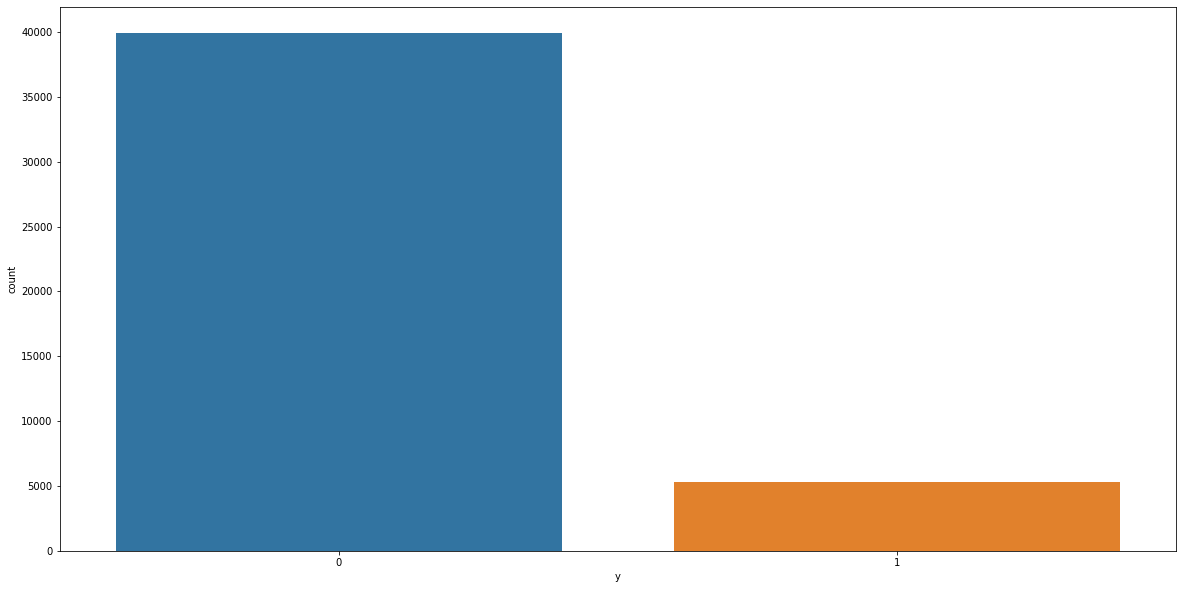

In [ ]:
sns.countplot(df['y']);

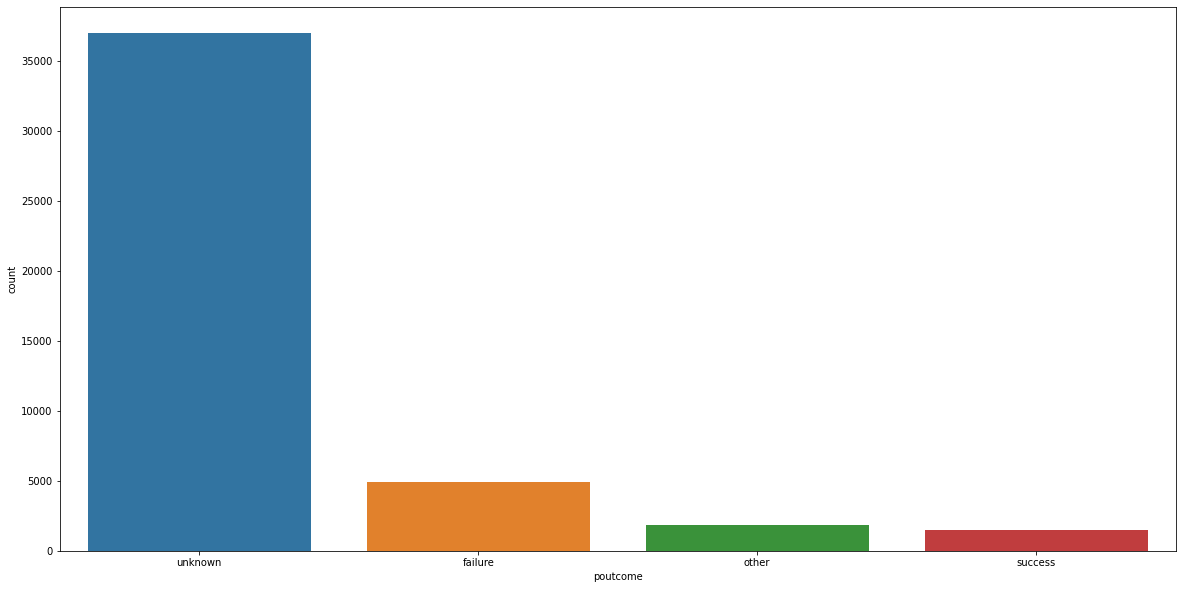

In [ ]:
sns.countplot(df['poutcome']);

In [ ]:
y_poutcome = pd.crosstab(df['y'],df['poutcome'], margins = True)
(y_poutcome/y_poutcome.loc['All']*100).round(1)

poutcome,failure,other,success,unknown,All
y,,,,,
0,87.4,83.3,35.3,90.8,88.3
1,12.6,16.7,64.7,9.2,11.7
All,100.0,100.0,100.0,100.0,100.0


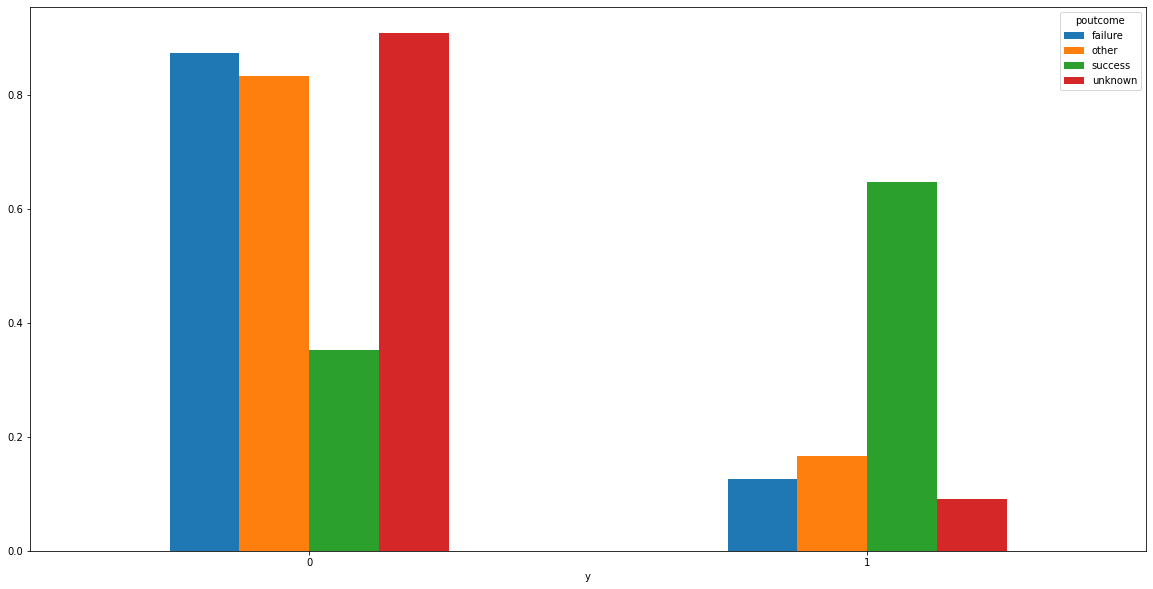

In [ ]:
y_poutcome = pd.crosstab(df['y'],df['poutcome'], normalize = 'columns')
y_poutcome.plot(kind = 'bar', stacked = False, rot = 0);

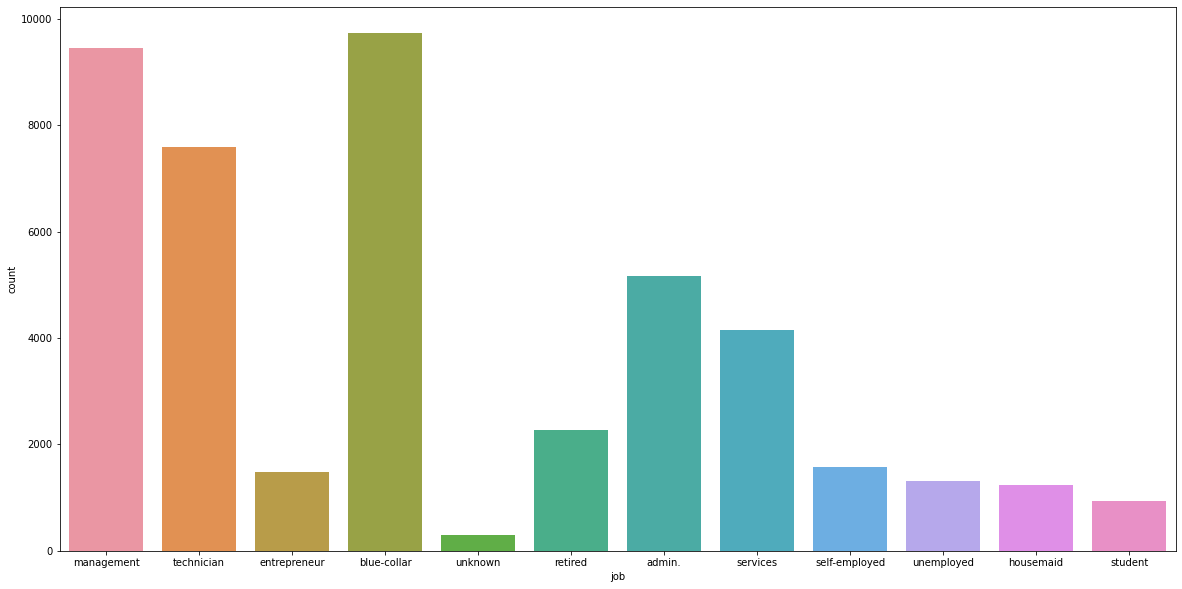

In [ ]:
plt.rc('figure', figsize=(20, 10))
sns.countplot(df['job']);

In [ ]:
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [ ]:
df['month'] = df['month'].replace('jan',1).replace('feb',2).replace('mar',3).replace('apr',4)\
                         .replace('may',5).replace('jun',6).replace('jul',7).replace('aug',8).replace('sep',9)\
                         .replace('oct',10).replace('nov',11).replace('dec',12)

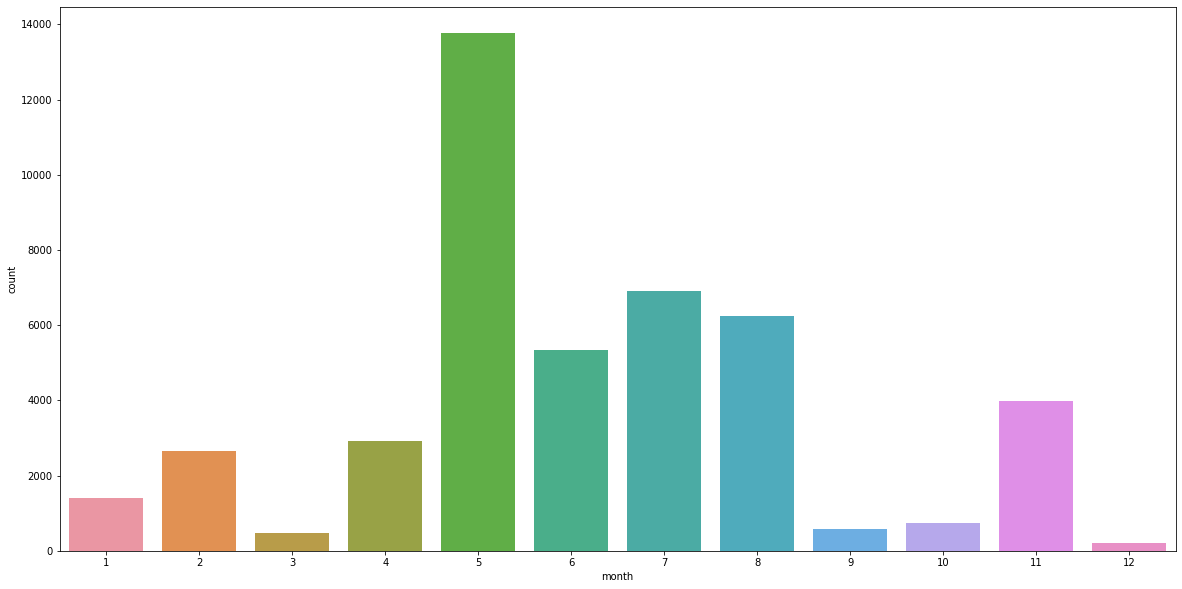

In [ ]:
plt.rc('figure', figsize=(20, 10))
sns.countplot(df['month']);

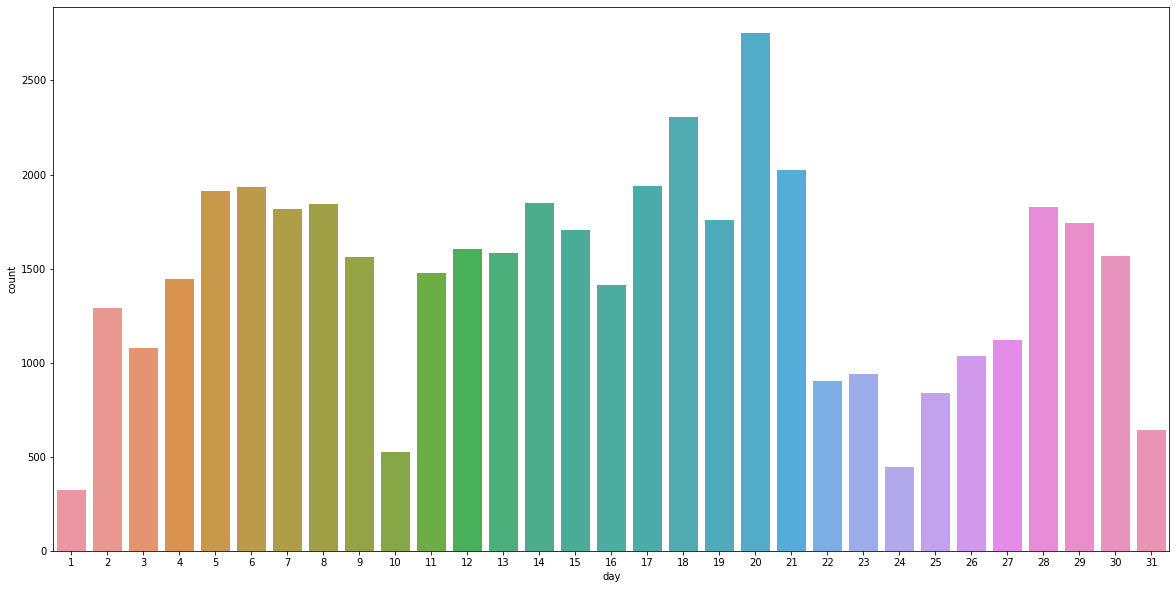

In [ ]:
sns.countplot(df['day']);

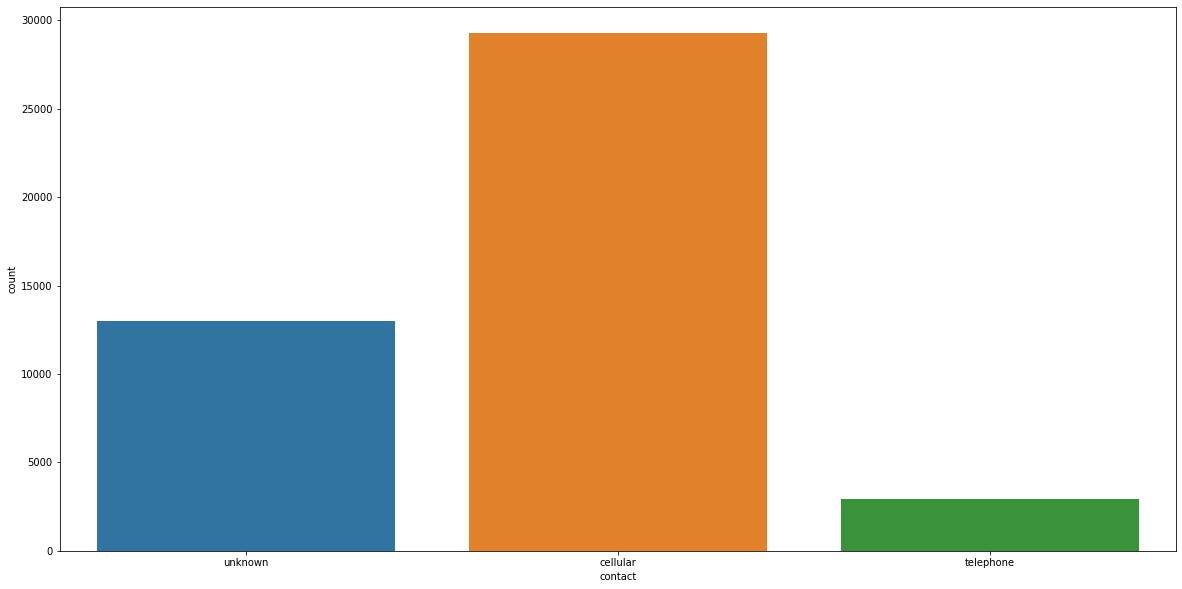

In [ ]:
sns.countplot(df['contact']);

In [ ]:
y_contact = pd.crosstab(df['y'],df['contact'], margins = True)
(y_contact/y_contact.loc['All']*100).round(1)

contact,cellular,telephone,unknown,All
y,,,,
0,85.1,86.6,95.9,88.3
1,14.9,13.4,4.1,11.7
All,100.0,100.0,100.0,100.0


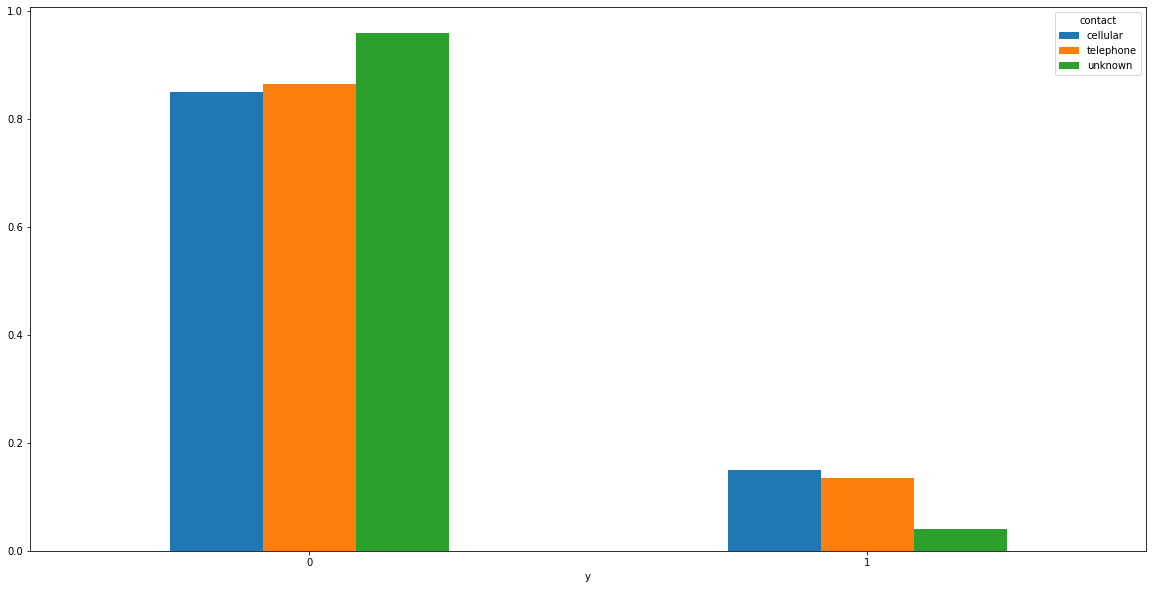

In [ ]:
y_contact = pd.crosstab(df['y'],df['contact'], normalize = 'columns')
y_contact.plot(kind = 'bar', stacked = False, rot = 0);

In [ ]:
y_month = pd.crosstab(df['y'],df['month'], margins = True)
(y_month/y_month.loc['All']*100).round(1)

month,1,2,3,4,5,6,7,8,9,10,11,12,All
y,,,,,,,,,,,,,
0,89.9,83.4,48.0,80.3,93.3,89.8,90.9,89.0,53.5,56.2,89.8,53.3,88.3
1,10.1,16.6,52.0,19.7,6.7,10.2,9.1,11.0,46.5,43.8,10.2,46.7,11.7
All,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


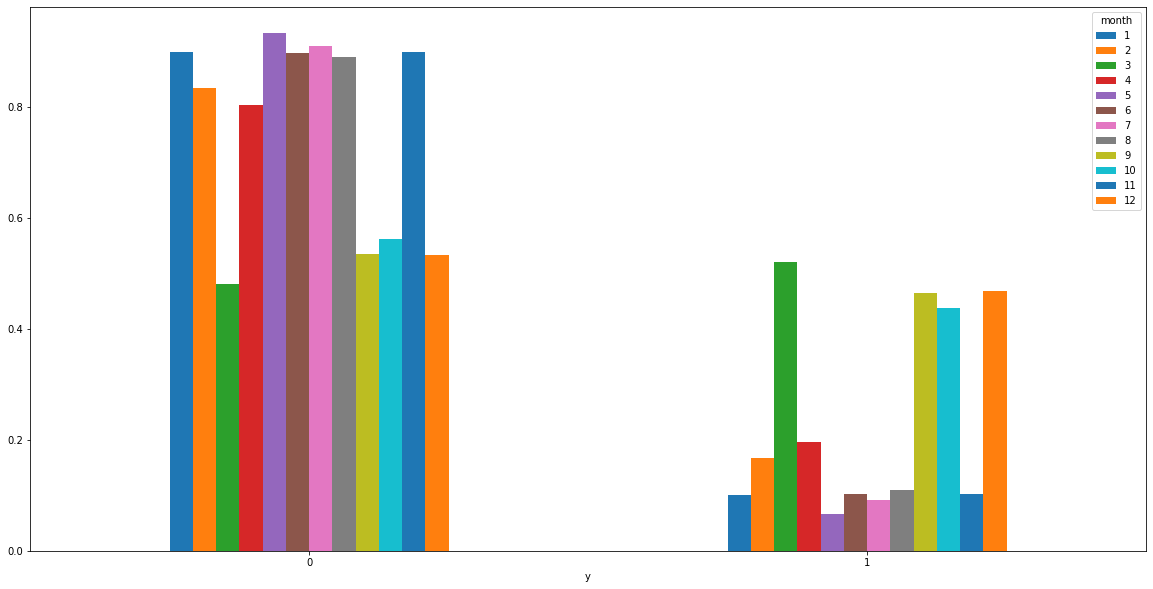

In [ ]:
y_month = pd.crosstab(df['y'],df['month'], normalize = 'columns')
y_month.plot(kind = 'bar', stacked = False, rot = 0);

In [ ]:
y_by_loan_n_comm_type = (pd.crosstab(index = [df['y'],
                                          df['contact']],
                                 columns = df['loan'],
                                 normalize = 'columns')*100).round(1)
y_by_loan_n_comm_type

loan            0     1
y contact              
0 cellular   54.0  60.9
  telephone   5.6   5.3
  unknown    27.7  27.1
1 cellular   10.5   5.4
  telephone   1.0   0.4
  unknown     1.2   1.0

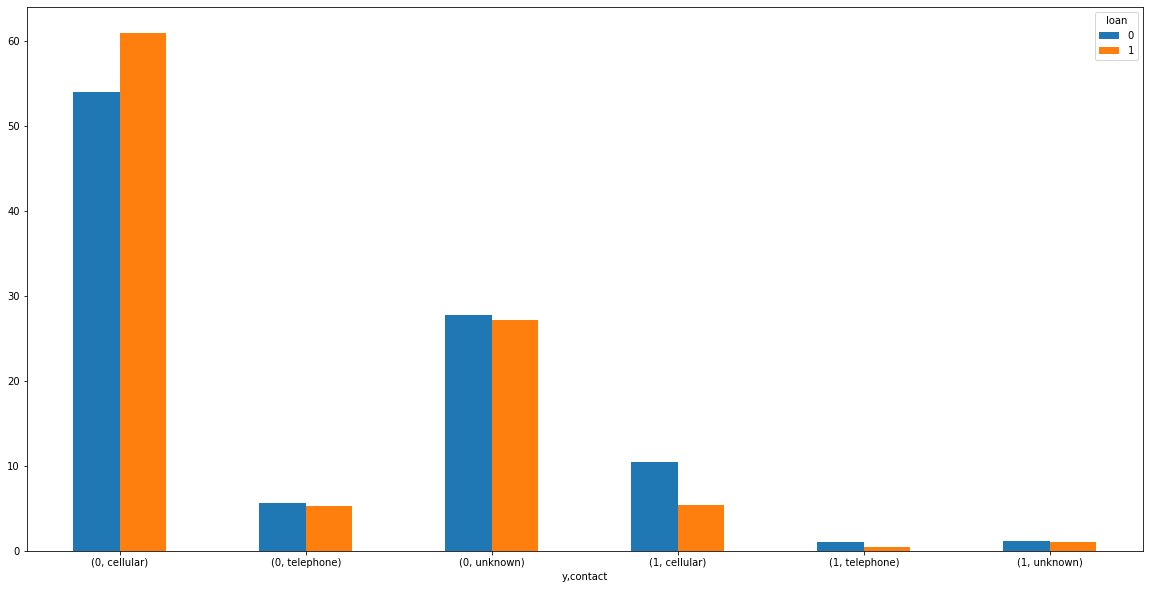

In [ ]:
y_by_loan_n_comm_type = (pd.crosstab(index = [df['y'],
                                          df['contact']],
                                 columns = df['loan'],
                                 normalize = 'columns')*100).round(1)
y_by_loan_n_comm_type.plot(kind = 'bar', stacked = False, rot = 0);

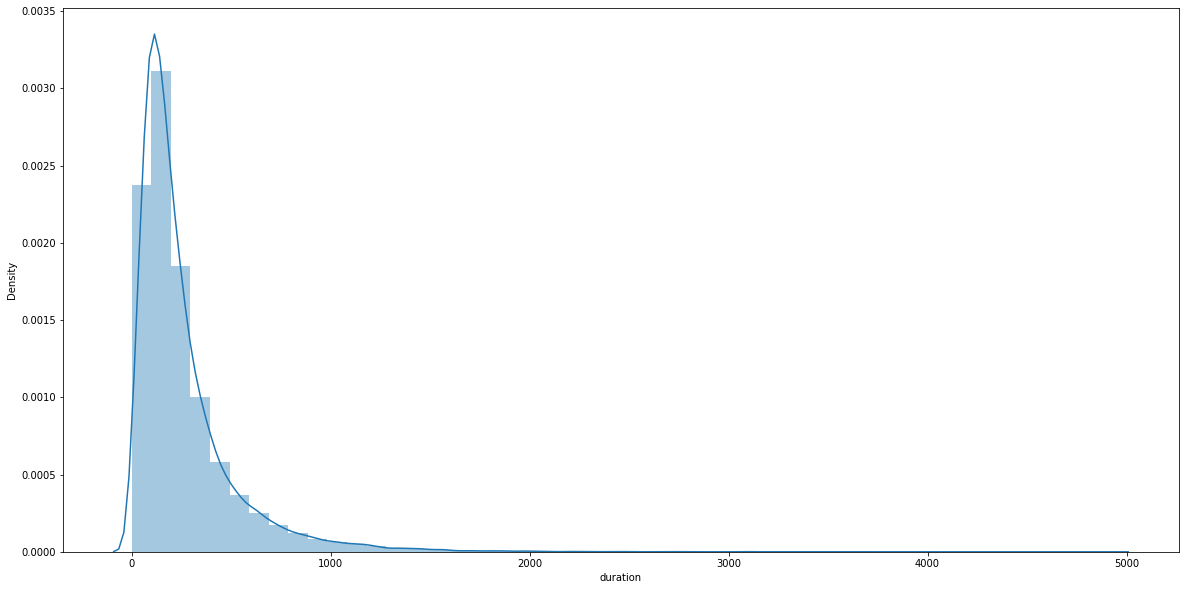

In [ ]:
sns.distplot(df['duration']);

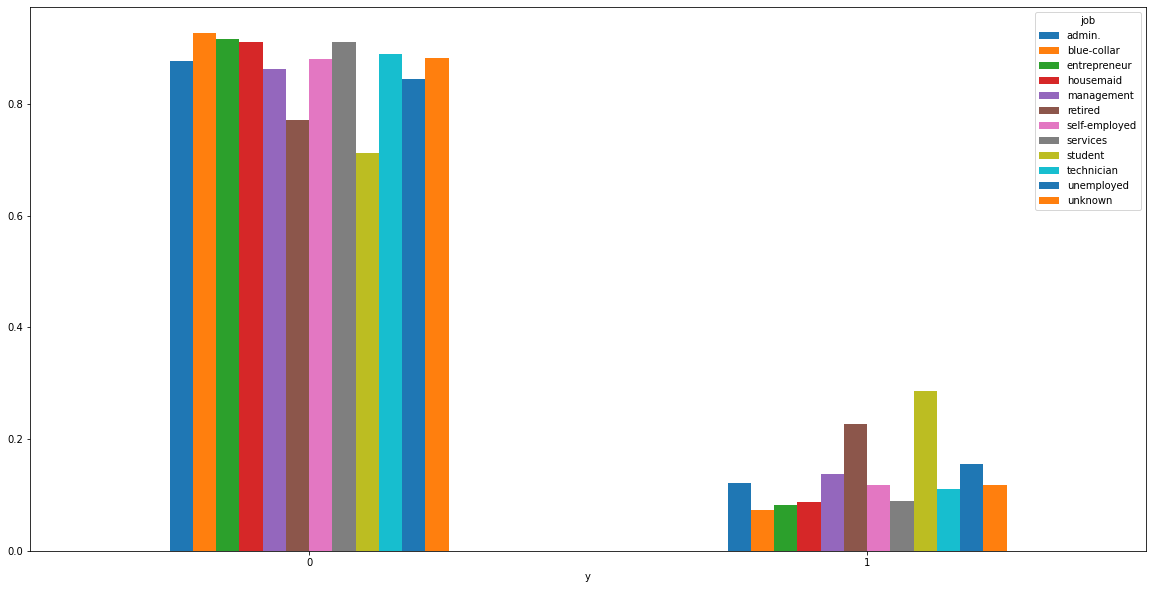

In [ ]:
y_job = pd.crosstab(df['y'],df['job'], normalize = 'columns')
y_job.plot(kind = 'bar', stacked = False, rot = 0);

In [ ]:
df['contact'].unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [ ]:
df['contact'] = df['contact'].replace('cellular',1).replace('unknown',0).replace('telephone',2)
df['contact'].unique()

array([0, 1, 2])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   job             45211 non-null  object  
 2   marital         45211 non-null  int64   
 3   education       45211 non-null  int64   
 4   default         45211 non-null  int64   
 5   balance         45211 non-null  int64   
 6   housing         45211 non-null  int64   
 7   loan            45211 non-null  int64   
 8   contact         45211 non-null  int64   
 9   day             45211 non-null  int64   
 10  month           45211 non-null  int64   
 11  duration        45211 non-null  int64   
 12  campaign        45211 non-null  int64   
 13  pdays           45211 non-null  int64   
 14  previous        45211 non-null  int64   
 15  poutcome        45211 non-null  object  
 16  y               45211 non-null  int64   
 17  purchased_lo

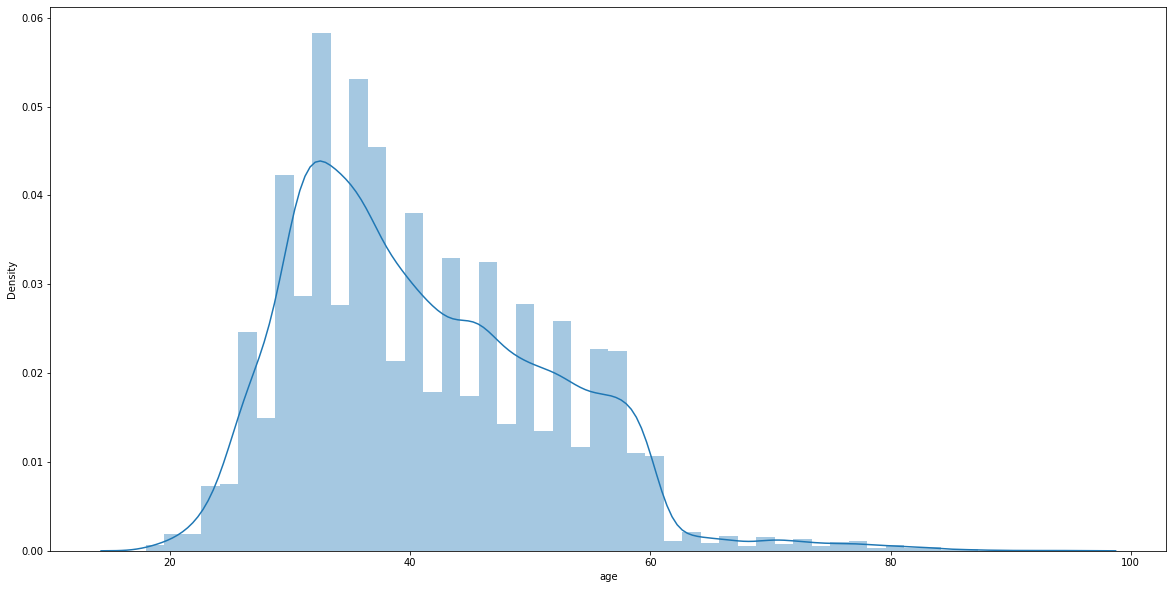

In [ ]:
sns.distplot(df['age']);

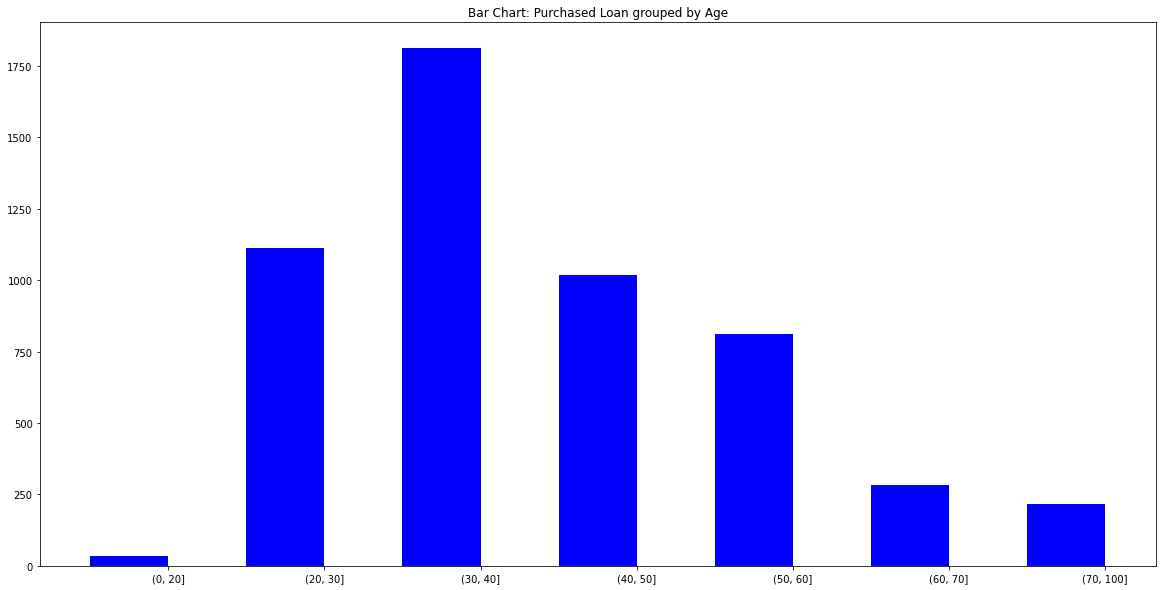

,purchased_loan,per
age_bin,,
"(0, 20]",33.0,0.623936
"(20, 30]",1112.0,21.024768
"(30, 40]",1812.0,34.259784
"(40, 50]",1019.0,19.266402
"(50, 60]",811.0,15.333711
"(60, 70]",284.0,5.369635
"(70, 100]",218.0,4.121762


In [ ]:
# Analysis: Groupby Age Bin
tp_age = pd.DataFrame([df.groupby('age_bin')['purchased_loan'].sum()])
tp_age = tp_age.T

tp_age['per'] = tp_age['purchased_loan'] / df['purchased_loan'].sum() * 100

ind = np.arange(7)
width = 0.50

fig, ax = plt.subplots()
Outcomebyage_chart = ax.bar(ind, tp_age['purchased_loan'], width, color='blue', align='center')

ax.set(title = 'Bar Chart: Purchased Loan grouped by Age', xticks = ind + width/2,
      xticklabels = [tp_age.index[0], tp_age.index[1], tp_age.index[2]
                    , tp_age.index[3], tp_age.index[4], tp_age.index[5]
                    , tp_age.index[6]])

plt.show()
tp_age
# (30, 40] - There is a meaningful distinction with the values for this attribute

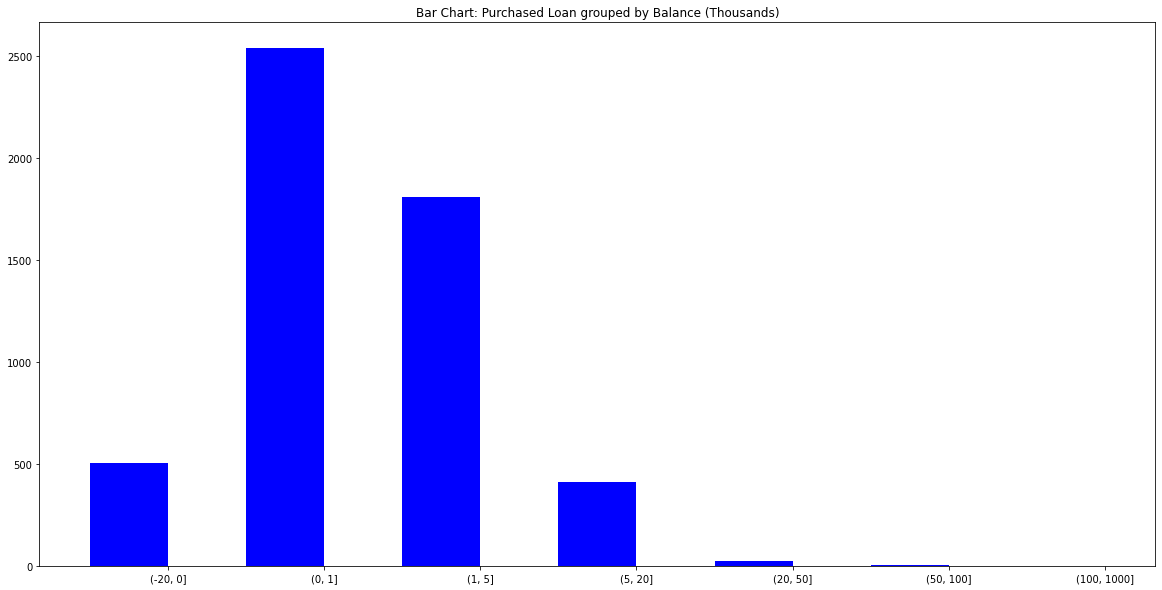

,purchased_loan,per
balance_bin,,
"(-20, 0]",502.0,9.491397
"(0, 1]",2539.0,48.005294
"(1, 5]",1807.0,34.165249
"(5, 20]",412.0,7.789752
"(20, 50]",25.0,0.472679
"(50, 100]",4.0,0.075629
"(100, 1000]",0.0,0.000000


In [ ]:
# Analysis: Groupby Balance Bin
tp_bal = pd.DataFrame([df.groupby('balance_bin')['purchased_loan'].sum()])
tp_bal = tp_bal.T

tp_bal['per'] = tp_bal['purchased_loan'] / df['purchased_loan'].sum() * 100

ind = np.arange(7)
width = 0.50

fig, ax = plt.subplots()
Outcomebybalance_chart = ax.bar(ind, tp_bal['purchased_loan'], width, color='blue', align='center')

ax.set(title = 'Bar Chart: Purchased Loan grouped by Balance (Thousands)', xticks = ind + width/2,
      xticklabels = [tp_bal.index[0], tp_bal.index[1], tp_bal.index[2]
                    , tp_bal.index[3], tp_bal.index[4], tp_bal.index[5]
                    , tp_bal.index[6]])

plt.show()
tp_bal
# (0, 1] - There is a meaningful distinction with the values for this attribute

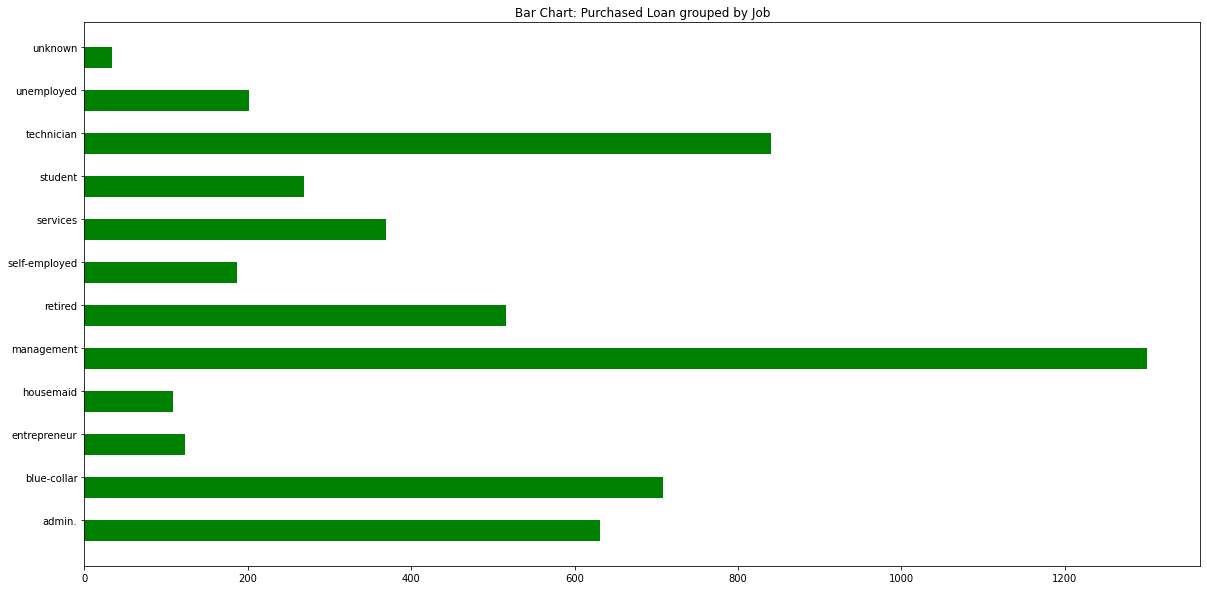

,purchased_loan,per
job,,
admin.,631.0,11.930422
blue-collar,708.0,13.386273
entrepreneur,123.0,2.325581
housemaid,109.0,2.060881
management,1301.0,24.598223
retired,516.0,9.756098
self-employed,187.0,3.535640
services,369.0,6.976744
student,269.0,5.086028


In [ ]:
# Analysis: Groupby Job
tp_job = pd.DataFrame([df.groupby('job')['purchased_loan'].sum()])
tp_job = tp_job.T

tp_job['per'] = tp_job['purchased_loan'] / df['purchased_loan'].sum() * 100

#ind = np.arange(7)
ind = np.arange(len(df['job'].unique()))
width = 0.50

fig, ax = plt.subplots()
Outcomebyjob_chart = ax.barh(ind, tp_job['purchased_loan'], width, color='green', align='center')

ax.set(title = 'Bar Chart: Purchased Loan grouped by Job', yticks = ind + width/2,
               yticklabels = [tp_job.index[0], tp_job.index[1], tp_job.index[2]
                    , tp_job.index[3], tp_job.index[4], tp_job.index[5]
                    , tp_job.index[6], tp_job.index[7], tp_job.index[8]
                    , tp_job.index[9], tp_job.index[10], tp_job.index[11]])
            
plt.show()
tp_job
# Management - There is a meaningful distinction with the values for this attribute

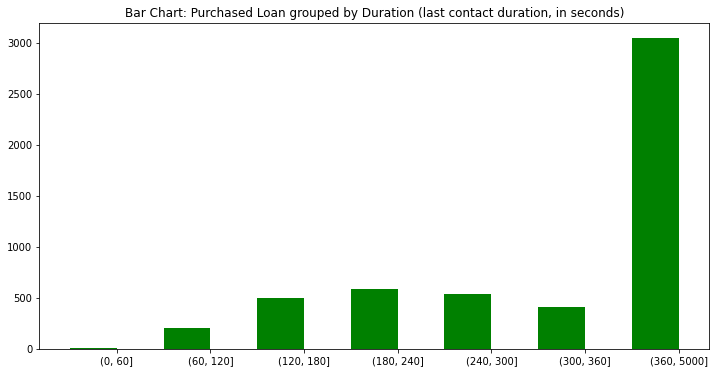

,purchased_loan,per
duration_bin,,
"(0, 60]",9.0,0.170164
"(60, 120]",202.0,3.819247
"(120, 180]",498.0,9.415769
"(180, 240]",583.0,11.022878
"(240, 300]",539.0,10.190962
"(300, 360]",412.0,7.789752
"(360, 5000]",3046.0,57.591227


In [ ]:
# Analysis: Groupby duration
tp_duration = pd.DataFrame([df.groupby('duration_bin')['purchased_loan'].sum()])
tp_duration = tp_duration.T

tp_duration['per'] = tp_duration['purchased_loan'] / df['purchased_loan'].sum() * 100

#ind = np.arange(7)
ind = np.arange(7)
width = 0.50

fig, ax = plt.subplots(figsize=(12,6))
Outcomebyduration_chart = ax.bar(ind, tp_duration['purchased_loan'], width, color='green', align='center')

ax.set(title = 'Bar Chart: Purchased Loan grouped by Duration (last contact duration, in seconds)', xticks = ind + width/2,
               xticklabels = [tp_duration.index[0], tp_duration.index[1], tp_duration.index[2]
                    , tp_duration.index[3], tp_duration.index[4], tp_duration.index[5]
                    , tp_duration.index[6]])
            
plt.show()
tp_duration
# (360, 5000] - There is a meaningful distinction with the values for this attribute
# There is a strong correlation between the last contact duration and the decision to
# purchase a Loan!

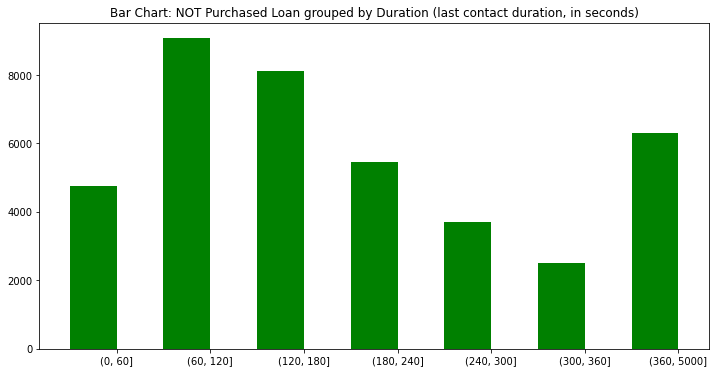

,purchased_loan,per
duration_bin,,
"(0, 60]",4754,11.908221
"(60, 120]",9076,22.734332
"(120, 180]",8118,20.334653
"(180, 240]",5451,13.654126
"(240, 300]",3704,9.278092
"(300, 360]",2508,6.282250
"(360, 5000]",6308,15.800812


In [ ]:
# Analysis: Groupby duration. Slice for NOT purchased Loans to verify correlation
df_bank_marketing_not_purch = df[df['purchased_loan'] == 0]
tp_duration_no = pd.DataFrame([df_bank_marketing_not_purch.groupby('duration_bin')['purchased_loan'].count()])
tp_duration_no = tp_duration_no.T

tp_duration_no['per'] = tp_duration_no['purchased_loan'] / df_bank_marketing_not_purch['purchased_loan'].count() * 100

#ind = np.arange(7)
ind = np.arange(7)
width = 0.50

fig, ax = plt.subplots(figsize=(12,6))
Outcomebyduration_no_chart = ax.bar(ind, tp_duration_no['purchased_loan'], width, color='green', align='center')

ax.set(title = 'Bar Chart: NOT Purchased Loan grouped by Duration (last contact duration, in seconds)', xticks = ind + width/2,
               xticklabels = [tp_duration_no.index[0], tp_duration_no.index[1], tp_duration_no.index[2]
                    , tp_duration_no.index[3], tp_duration_no.index[4], tp_duration_no.index[5]
                    , tp_duration_no.index[6]])
            
plt.show()
tp_duration_no
# There is No meaningful distinction with the values for this attribute for the NOT
# purchased Loan. This confirms the correlation on the Purchased Loans!

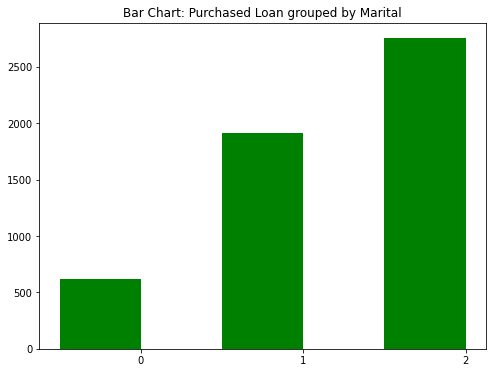

,purchased_loan,per
marital,,
0,622.0,11.760257
1,1912.0,36.150501
2,2755.0,52.089242


In [ ]:
# Analysis: Groupby marital
tp_marital = pd.DataFrame([df.groupby('marital')['purchased_loan'].sum()])
tp_marital = tp_marital.T

tp_marital['per'] = tp_marital['purchased_loan'] / df['purchased_loan'].sum() * 100

#ind = np.arange(7)
ind = np.arange(3)
width = 0.50

fig, ax = plt.subplots(figsize=(8,6))
Outcomebymarital_chart = ax.bar(ind, tp_marital['purchased_loan'], width, color='green', align='center')

ax.set(title = 'Bar Chart: Purchased Loan grouped by Marital', xticks = ind + width/2,
               xticklabels = [tp_marital.index[0], tp_marital.index[1], tp_marital.index[2]])

plt.show()
tp_marital
#Not Divorced - There is a meaningful distinction with the values for this attribute

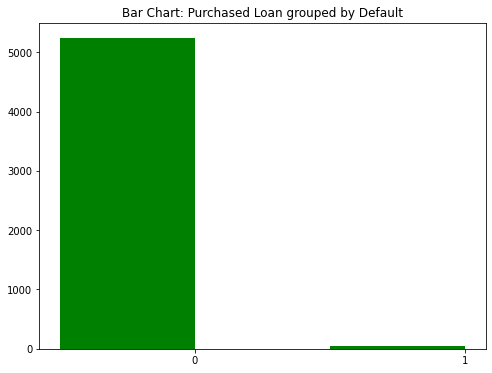

,purchased_loan,per
default,,
0,5237.0,99.016827
1,52.0,0.983173


In [ ]:
# Analysis: Groupby default
tp_default = pd.DataFrame([df.groupby('default')['purchased_loan'].sum()])
tp_default = tp_default.T

tp_default['per'] = tp_default['purchased_loan'] / df['purchased_loan'].sum() * 100

#ind = np.arange(7)
ind = np.arange(2)
width = 0.50

fig, ax = plt.subplots(figsize=(8,6))
Outcomebydefault_chart = ax.bar(ind, tp_default['purchased_loan'], width, color='green', align='center')

ax.set(title = 'Bar Chart: Purchased Loan grouped by Default', xticks = ind + width/2,
               xticklabels = [tp_default.index[0], tp_default.index[1]])

plt.show()
tp_default
#Not Divorced - There is a meaningful distinction with the values for this attribute

# Predictive Statistics Section

- Based on the dataset and the classification goal, i.e. to predict if the client subscribes to the Bank's Term Loan (Yes / No) a logistic Regression Model seems like the best candidate from the ones covered on this course.  
- We are including two Logistic models, one from the scipy library and another from the sklearn library.  
- The final section compares diferent models and finds the best model for our problem. A Random Forest Algorithm seems to be slightly better than the Logistic model but since it wasn't covered on this course we did not choose it as the main model. This comparison allows us to certify that the Logistic Regression Model was a good choice for this problem.


In [ ]:
# Logit Model

predictors = ['age', 'duration', 'job_cat', 'balance', 'marital_cat', 'education_cat'\
              , 'default_cat']
m1 = Logit(df_bank_marketing_balanced['purchased_loan'], df_bank_marketing_balanced[predictors])
m1 = m1.fit()

Optimization terminated successfully.
         Current function value: 0.572958
         Iterations 6


In [ ]:
m1.params

age             -0.027261
duration         0.003903
job_cat          0.006907
balance          0.000061
marital_cat     -0.291275
education_cat    0.102967
default_cat     -1.004661
dtype: float64

In [ ]:
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.173     
Dependent Variable: purchased_loan   AIC:              12135.5013
Date:               2020-12-01 16:08 BIC:              12186.3670
No. Observations:   10578            Log-Likelihood:   -6060.8   
Df Model:           6                LL-Null:          -7332.1   
Df Residuals:       10571            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age              -0.0273   0.0012 -23.4866 0.0000 -0.0295 -0.0250
duration          0.0039   0.0001  38.1204 0.0000  0.0037  0.0041
job_cat           0.0069   0.0067   1.0299 0.3030 -0.0062  0.0201
balance           0.0001   0.0000   

In [ ]:
# Derive the estimates of the odds.
# Assigned predicted value to new column 'p'

df_bank_marketing_balanced.loc[:, 'p'] = m1.predict(df_bank_marketing_balanced[predictors])

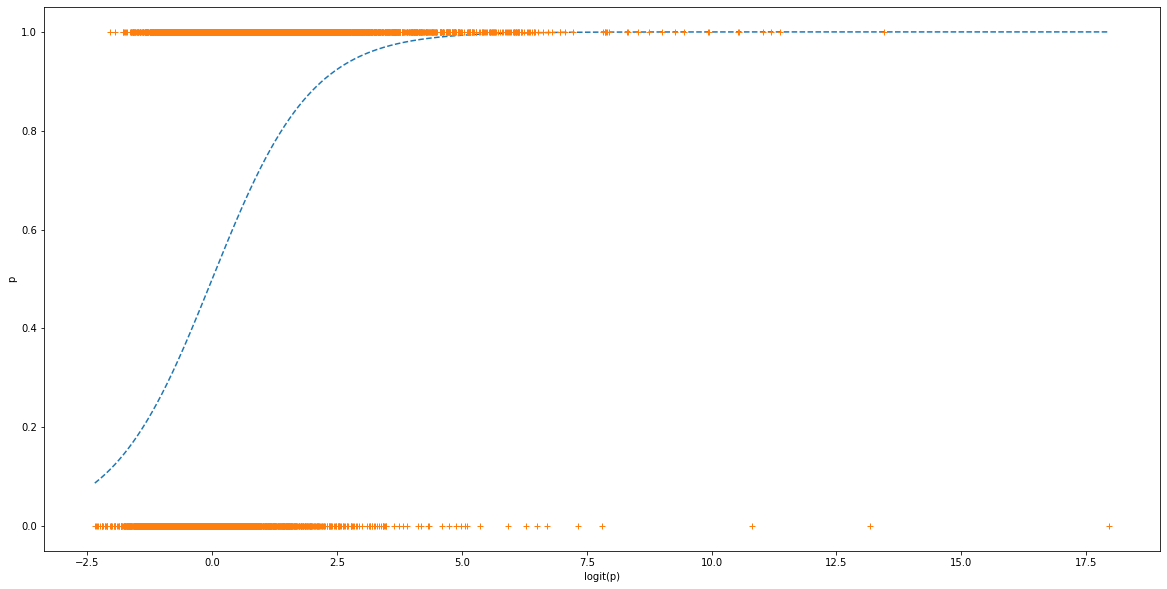

In [ ]:
# Plot the relationship between the values of logit(p) and odds (p) along the actual values of the response (purchased_loan).

df_bank_marketing_balanced = df_bank_marketing_balanced.sort_values(by = ['p'], axis = 0)
plt.plot(logit(df_bank_marketing_balanced.p), df_bank_marketing_balanced.p, '--')
plt.plot(logit(df_bank_marketing_balanced.p), df_bank_marketing_balanced.purchased_loan, '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.show()

# Logistic Regression Section

In [ ]:

df_bank_marketing_balanced.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,purchased_loan,default_cat,housing_cat,loan_cat,job_cat,marital_cat,education_cat,age_bin,balance_bin,duration_bin,p
4629,51,entrepreneur,single,tertiary,yes,15,no,no,unknown,11,jun,104,2,-1,0,unknown,no,0,1,0,0,2,2,2,"(50, 60]","(0, 1]","(60, 120]",0.086989
7087,34,blue-collar,single,primary,yes,81,no,yes,cellular,9,feb,44,2,-1,0,unknown,no,0,1,0,1,1,2,0,"(30, 40]","(0, 1]","(0, 60]",0.088628
7901,51,admin.,married,unknown,yes,-12,no,no,cellular,20,aug,18,7,-1,0,unknown,no,0,1,0,0,0,1,3,"(50, 60]","(-20, 0]","(0, 60]",0.090477
2239,51,management,single,tertiary,yes,-55,yes,no,cellular,18,aug,119,6,-1,0,unknown,no,0,1,1,0,4,2,2,"(50, 60]","(-20, 0]","(60, 120]",0.092550
4178,43,technician,single,secondary,yes,685,yes,no,cellular,18,nov,78,1,110,2,failure,no,0,1,1,0,9,2,1,"(40, 50]","(0, 1]","(60, 120]",0.095520


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_bank_marketing_balanced[predictors], df_bank_marketing_balanced['purchased_loan'], test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test) * 100) + "%")

Accuracy of logistic regression classifier on test set: 71.50%


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[809 210]
 [393 704]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.79      0.73      1019
           1       0.77      0.64      0.70      1097

    accuracy                           0.72      2116
   macro avg       0.72      0.72      0.71      2116
weighted avg       0.72      0.72      0.71      2116



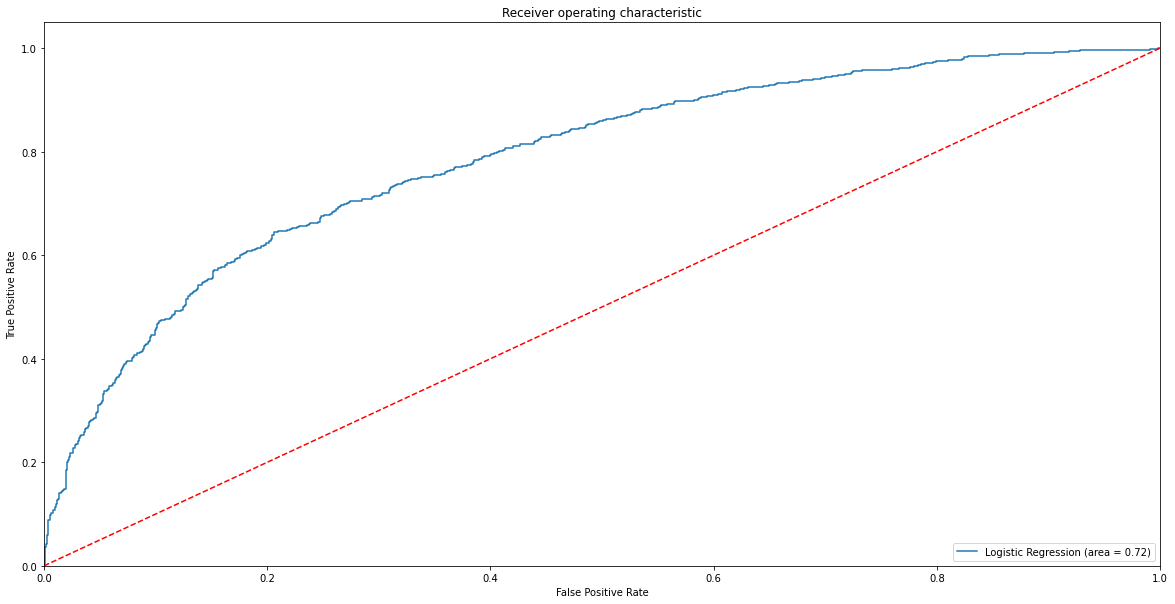

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   job             45211 non-null  object  
 2   marital         45211 non-null  int64   
 3   education       45211 non-null  int64   
 4   default         45211 non-null  int64   
 5   balance         45211 non-null  int64   
 6   housing         45211 non-null  int64   
 7   loan            45211 non-null  int64   
 8   contact         45211 non-null  int64   
 9   day             45211 non-null  int64   
 10  month           45211 non-null  int64   
 11  duration        45211 non-null  int64   
 12  campaign        45211 non-null  int64   
 13  pdays           45211 non-null  int64   
 14  previous        45211 non-null  int64   
 15  poutcome        45211 non-null  object  
 16  y               45211 non-null  int64   
 17  purchased_lo

In [ ]:
dummy_jobs = pd.get_dummies(df['job'], prefix='job')
df = df.join(dummy_jobs)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,purchased_loan,default_cat,housing_cat,loan_cat,job_cat,marital_cat,education_cat,age_bin,balance_bin,duration_bin,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,management,2,3,0,2143,1,0,0,5,5,261,1,-1,0,unknown,0,0,0,1,0,4,1,2,"(50, 60]","(1, 5]","(240, 300]",0,0,0,0,1,0,0,0,0,0,0,0
1,44,technician,1,2,0,29,1,0,0,5,5,151,1,-1,0,unknown,0,0,0,1,0,9,2,1,"(40, 50]","(0, 1]","(120, 180]",0,0,0,0,0,0,0,0,0,1,0,0
2,33,entrepreneur,2,2,0,2,1,1,0,5,5,76,1,-1,0,unknown,0,0,0,1,1,2,1,1,"(30, 40]","(0, 1]","(60, 120]",0,0,1,0,0,0,0,0,0,0,0,0
3,47,blue-collar,2,0,0,1506,1,0,0,5,5,92,1,-1,0,unknown,0,0,0,1,0,1,1,3,"(40, 50]","(1, 5]","(60, 120]",0,1,0,0,0,0,0,0,0,0,0,0
4,33,unknown,1,0,0,1,0,0,0,5,5,198,1,-1,0,unknown,0,0,0,0,0,11,2,3,"(30, 40]","(0, 1]","(180, 240]",0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.describe()

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,purchased_loan,default_cat,housing_cat,loan_cat,job_cat,marital_cat,education_cat,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.00000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1.486762,2.060516,0.018027,1362.272058,0.555838,0.160226,0.776293,15.806419,6.144655,258.163080,2.763841,40.197828,0.580323,0.116985,0.116985,0.018027,0.555838,0.160226,4.339762,1.167725,1.224813,0.114375,0.215257,0.032890,0.027427,0.209197,0.050076,0.034925,0.09188,0.020747,0.168034,0.028820,0.006370
std,10.618762,0.692948,0.778704,0.133049,3044.765829,0.496878,0.366820,0.549747,8.322476,2.408034,257.527812,3.098021,100.128746,2.303441,0.321406,0.321406,0.133049,0.496878,0.366820,3.272657,0.608230,0.747997,0.318269,0.411005,0.178351,0.163326,0.406740,0.218105,0.183592,0.28886,0.142538,0.373901,0.167303,0.079559
min,18.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,2.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,5.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,2.000000,2.000000,0.000000,448.000000,1.000000,0.000000,1.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,2.000000,3.000000,0.000000,1428.000000,1.000000,0.000000,1.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,95.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,12.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df['poutcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [ ]:
# consider the group the poutcome four category into two: one is success (1) and the other is failure (0)

df['poutcome'] = df['poutcome'].replace('unknown',0).replace('failure',0).replace('other',0).replace('success',1)
df['poutcome'].unique()

array([0, 1])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                45211 non-null  int64   
 1   job                45211 non-null  object  
 2   marital            45211 non-null  int64   
 3   education          45211 non-null  int64   
 4   default            45211 non-null  int64   
 5   balance            45211 non-null  int64   
 6   housing            45211 non-null  int64   
 7   loan               45211 non-null  int64   
 8   contact            45211 non-null  int64   
 9   day                45211 non-null  int64   
 10  month              45211 non-null  int64   
 11  duration           45211 non-null  int64   
 12  campaign           45211 non-null  int64   
 13  pdays              45211 non-null  int64   
 14  previous           45211 non-null  int64   
 15  poutcome           45211 non-null  int64   
 16  y   

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'purchased_loan', 'default_cat',
       'housing_cat', 'loan_cat', 'job_cat', 'marital_cat', 'education_cat',
       'age_bin', 'balance_bin', 'duration_bin', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown'],
      dtype='object')

In [ ]:
df = df.drop(['job'], axis = 1)
df.head()

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,purchased_loan,default_cat,housing_cat,loan_cat,job_cat,marital_cat,education_cat,age_bin,balance_bin,duration_bin,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,2,3,0,2143,1,0,0,5,5,261,1,-1,0,0,0,0,0,1,0,4,1,2,"(50, 60]","(1, 5]","(240, 300]",0,0,0,0,1,0,0,0,0,0,0,0
1,44,1,2,0,29,1,0,0,5,5,151,1,-1,0,0,0,0,0,1,0,9,2,1,"(40, 50]","(0, 1]","(120, 180]",0,0,0,0,0,0,0,0,0,1,0,0
2,33,2,2,0,2,1,1,0,5,5,76,1,-1,0,0,0,0,0,1,1,2,1,1,"(30, 40]","(0, 1]","(60, 120]",0,0,1,0,0,0,0,0,0,0,0,0
3,47,2,0,0,1506,1,0,0,5,5,92,1,-1,0,0,0,0,0,1,0,1,1,3,"(40, 50]","(1, 5]","(60, 120]",0,1,0,0,0,0,0,0,0,0,0,0
4,33,1,0,0,1,0,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,11,2,3,"(30, 40]","(0, 1]","(180, 240]",0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df = df.drop(['default_cat', 'purchased_loan',
              'housing_cat', 'loan_cat', 'job_cat', 'marital_cat', 'education_cat',
              'age_bin', 'balance_bin', 'duration_bin'], axis = 1)
df.head()

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,2,3,0,2143,1,0,0,5,5,261,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,44,1,2,0,29,1,0,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,33,2,2,0,2,1,1,0,5,5,76,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,47,2,0,0,1506,1,0,0,5,5,92,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,33,1,0,0,1,0,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                45211 non-null  int64
 1   marital            45211 non-null  int64
 2   education          45211 non-null  int64
 3   default            45211 non-null  int64
 4   balance            45211 non-null  int64
 5   housing            45211 non-null  int64
 6   loan               45211 non-null  int64
 7   contact            45211 non-null  int64
 8   day                45211 non-null  int64
 9   month              45211 non-null  int64
 10  duration           45211 non-null  int64
 11  campaign           45211 non-null  int64
 12  pdays              45211 non-null  int64
 13  previous           45211 non-null  int64
 14  poutcome           45211 non-null  int64
 15  y                  45211 non-null  int64
 16  job_admin.         45211 non-null  uint8
 17  job_blue-col

In [ ]:
feature_list = list(df.columns)
feature_list.remove('y')
print(feature_list) # prepare a list of features for modeling

['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown']


In [ ]:
feature_df = pd.DataFrame(columns = ['feature'])
feature_df['feature'] = feature_list

In [ ]:
feature_df.to_csv("features.csv") # save the feature list to csv for later modeling use and easy to edit if needed

In [ ]:
df.to_csv('cleaned_ads.csv') # save the cleaned data into analytical dataset for modeling use later

In [ ]:
# Pedro's codes to create balanced analytical data set
df_yes = df[df['y'] == 1]
df_no = df[df['y'] == 0].sample(n=len(df_yes))
df_balanced = pd.concat([df_yes, df_no])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
df_balanced['y'].value_counts()

1    5289
0    5289
Name: y, dtype: int64

In [ ]:
df.columns # double check the features for modeling

Index(['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown'],
      dtype='object')

features.csv
cleaned_ads.csv
(10578, 27) 10578
(10578, 27) 10578
(8462, 27) 8462 (2116, 27) 2116
2020-12-01 16:23:57.121358
LR: 0.807656
2020-12-01 16:23:57.148914
LDA: 0.799622
2020-12-01 16:23:57.209293
CART: 0.778355
2020-12-01 16:23:57.301522
NB: 0.720227
2020-12-01 16:23:57.312911
RF: 0.844991
2020-12-01 16:23:58.501252


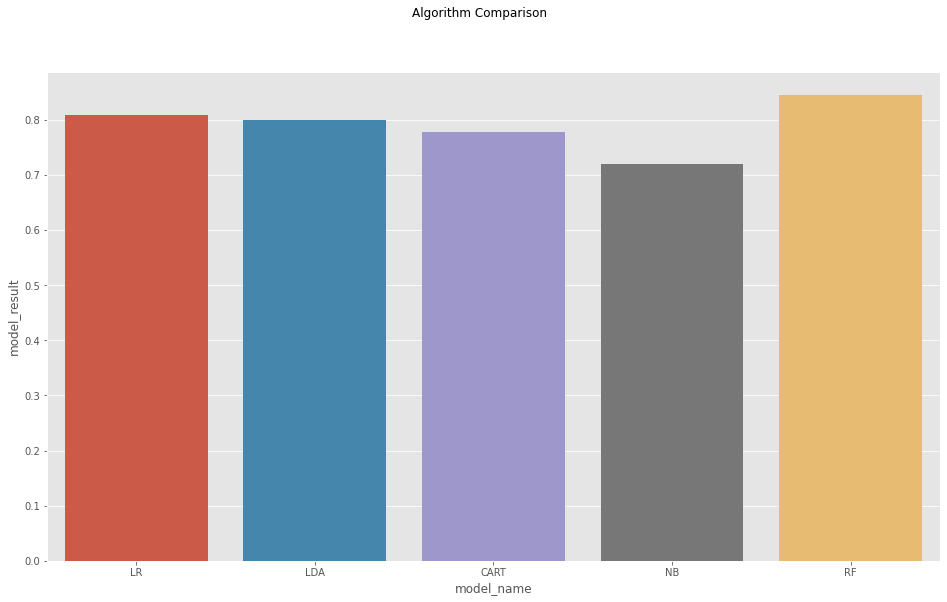

No handles with labels found to put in legend.


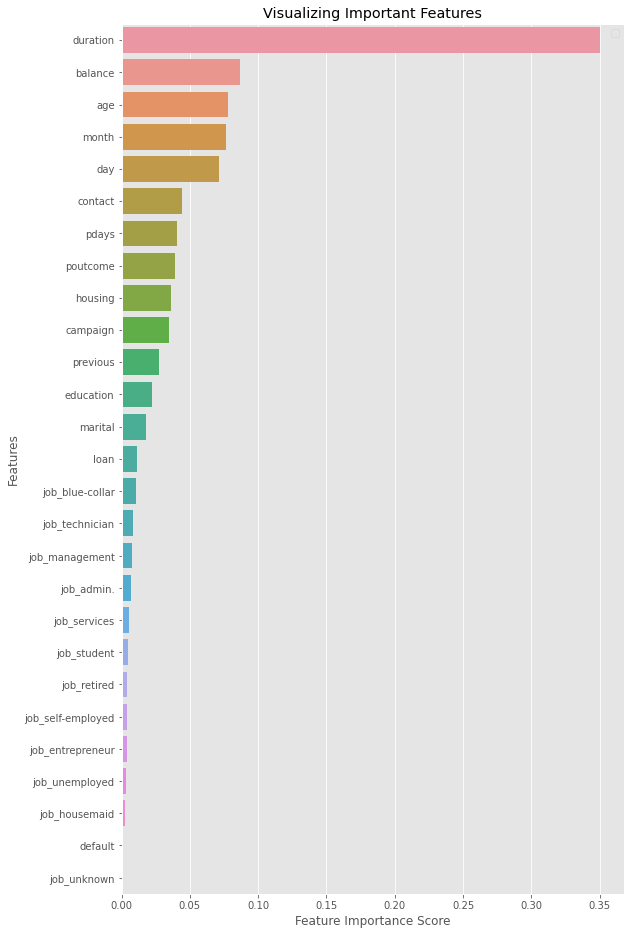

In [ ]:
from pandas.plotting import scatter_matrix  
from sklearn import model_selection 
from sklearn import metrics
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score  
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import svm, preprocessing
from sklearn.svm import SVC
import seaborn as sns

from matplotlib import style
style.use("ggplot")
%matplotlib inline

def Build_Data_Set():
    
    features = []
    features_df = pd.read_csv("features.csv")
    features = features_df['feature'].tolist() # list of 31 features
    
    ads_df = pd.read_csv('cleaned_ads.csv')
    
    print("features.csv")
    print('cleaned_ads.csv')
    
    ads_df_yes = ads_df[ads_df['y'] == 1]
    ads_df_no = ads_df[ads_df['y'] == 0].sample(n=len(ads_df_yes))
    ads_df_balanced = pd.concat([ads_df_yes, ads_df_no])
    ads_df_balanced = ads_df_balanced.sample(frac=1).reset_index(drop=True)
    
    ads_df_balanced.replace([np.inf, -np.inf], 0)
    
    X = np.array(ads_df_balanced[features].values)
    y = ads_df_balanced["y"].values.tolist() 
    X = preprocessing.scale(X)
    
    return X, y, features

def model_comparison(X_training, y_training, features, seed = 7, splits = 10, validation_size = 0.20, scoring = 'roc_auc'):
    
    # A quick model comparison (all models using the default parameters)
    # to get a general idea on which ones tend to perform better
    
    # Preparing the train and validation ADS - Analytical Dataset.
    
    print(X_training.shape, len(y_training))
    
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_training,
                                                                                    y_training,
                                                                                    test_size=validation_size,
                                                                                    random_state=seed)
    
    print(X_train.shape, len(Y_train), X_validation.shape, len(Y_validation))
    
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
#     models.append(('KNN', KNeighborsClassifier())) # too computation expensive on big data set (3M observation) to complete
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
#     models.append(('SVM', SVC())) # too computation expensive on big data set (3M records/observations) to complete
    models.append(('RF', RandomForestClassifier()))

    # Evaluate each model in turn
    
    results = []
    names = []
    for name, model in models:
#         kfold = model_selection.KFold(n_splits=splits, random_state=seed)
        print(datetime.now())
#         cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring, n_jobs = -1)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_validation)
        result = metrics.accuracy_score(Y_validation, Y_pred)
        results.append(result)
        names.append(name)
        msg = "%s: %f" % (name, result)
        print(msg)
    
    # get the last model (RF) feature importance
    feature_imp = pd.Series(model.feature_importances_, index = features).sort_values(ascending = False)
    
    print(datetime.now())

    # Compare Algorithms
    fig = plt.figure(figsize = (16,9))
    fig.suptitle('Algorithm Comparison')
    df = pd.DataFrame(list(zip(names,results)),columns=['model_name', 'model_result'])
    ax = sns.barplot(x='model_name',y='model_result', data=df)
    ax.set_xticklabels(names)
    plt.show()
    
    return feature_imp

def model_tuning():
    
    # Build the ADS for model tuning
    
    X_training, y_training, features = Build_Data_Set()
    print(X_training.shape, len(y_training))
    
    # model comparison will return Randomforest model output - feature importance
    feature_imp = model_comparison(X_training, y_training, features)
    
    fig, ax = plt.subplots(figsize=(9, 16))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()


model_tuning()